<a href="https://colab.research.google.com/github/owoMarciN/Python/blob/main/Intro-AI/AI_Parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install torch
!pip install torchvision
!pip install --upgrade ucimlrepo
!pip install optuna
!pip install confopt

In [2]:
from ucimlrepo import fetch_ucirepo, list_available_datasets

# check which datasets can be imported
#list_available_datasets()

# import dataset
park = fetch_ucirepo(id=174)

# access data
X = park.data.features
y = park.data.targets
# train model e.g. sklearn.linear_model.LinearRegression().fit(X, y)

# access metadata
# print(park.metadata.uci_id)
# print(park.metadata.num_instances)
# print(park.metadata.additional_info.summary)

# access variable info in tabular format
# print(park.variables)

In [3]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# SciKit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [5]:
# Ploting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Checking the data

# print(X.describe())
# print(y)

In [ ]:
# Class distribution plot

sns.countplot(x=y['status'])
plt.title("Class distribution")
plt.xlabel("Classes (0 - Healthy, 1 - Parkinson)")
plt.ylabel("Count")
plt.show()

In [ ]:
pp_data = X[['MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:RAP', 'MDVP:PPQ']]

sns.pairplot(pp_data)
plt.show()

In [12]:
import time

class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(params, lr=lr)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum)
    if name == "adam":
        return optim.Adam(params, lr=lr)
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum)
    raise ValueError("Unknown optimizer")

In [ ]:
def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time

In [21]:
X = StandardScaler().fit_transform(X).astype('float32')
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y)

Xtr, Xte = map(torch.tensor, (Xtr, Xte))
ytr, yte = map (lambda v : torch.tensor(v.values).float(), (ytr, yte))

In [ ]:
losses, metrics, elapsed_time = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
print(f"Baseline metrics (opt_name=Adam)\n {metrics}")
print(f"Elapsed time: {elapsed_time:.4f} seconds")

In [ ]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.savefig("lossfun.png")
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")

In [ ]:
def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    f1_scores = []

    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        model.eval()
        with torch.no_grad():
            y_prob = model(Xte).numpy()
        y_pred = (y_prob >= 0.5).astype(int)
        f1_scores.append(f1_score(yte, y_pred))

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time, f1_scores

In [ ]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []

for opt_name in opt:
    losses, metrics, elapsed_time, f1_scores = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(f1_scores)

for i, opt_name in enumerate(opt):
    plt.plot(f1_all[i], label=opt_name)
plt.legend()
plt.show()

In [ ]:
from torch.optim.lr_scheduler import StepLR

def train_and_eval(opt_name, lr, epochs, momentum, Xtr, Xte, ytr, yte, in_dim=30):
    start_time = time.time()
    model = MLP(in_dim=in_dim)
    optimizer = get_optimizer(opt_name, model.parameters(), lr, momentum)
    criterion = nn.BCELoss()
    losses = []
    l_rates = []

    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr)
        loss.backward()

        losses.append(loss.item())
        l_rates.append(scheduler.get_last_lr())

        optimizer.step()
        scheduler.step()

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)
    end_time = time.time()
    elapsed_time = end_time - start_time

    return losses, {
            "acc": accuracy_score(yte, y_pred),
            "prec": precision_score(yte, y_pred),
            "rec": recall_score(yte, y_pred),
            "f1": f1_score(yte, y_pred),
            "auc": roc_auc_score(yte, y_prob)
    }, elapsed_time, l_rates


In [ ]:
# baseline MLP
opt = ["adam", "sgd", "momentum", "rmsprop"]
losses_all = []
f1_all = []
acc_all = []
epochs = []
elapsed_times = []
lr_all = []

for opt_name in opt:
    losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name=opt_name, lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr, Xte=Xte, ytr=ytr, yte=yte, in_dim=Xtr.shape[1])
    f1_all.append(metrics["f1"])
    acc_all.append(metrics["acc"])
    losses_all.append(losses)
    lr_all.append(l_rates)
    elapsed_times.append(elapsed_time)

for i, opt_name in enumerate(opt):
    plt.plot(losses_all[i], label=opt_name)
plt.legend()
plt.show()

for i, opt_name in enumerate(opt):
    print(f"{opt_name:10s}  acc={acc_all[i]:.4f}  f1={f1_all[i]:.4f}  time={elapsed_times[i]:.4f}s")


for i, opt_name in enumerate(opt):
    plt.plot(lr_all[i])
plt.show()

In [6]:
def kmeans_features(X_train, X_test, n_clusters=8, random_state=42):
    # Ensure inputs are NumPy arrays for KMeans and subsequent NumPy operations
    if isinstance(X_train, torch.Tensor):
        X_train_np = X_train.numpy()
    else:
        X_train_np = X_train

    if isinstance(X_test, torch.Tensor):
        X_test_np = X_test.numpy()
    else:
        X_test_np = X_test

    kmeans = KMeans(n_clusters=n_clusters,
    n_init=10,
    random_state=random_state)
    kmeans.fit(X_train_np)

    def to_dist(X_arr):
        # X_arr will already be a NumPy array if the outer conversion happened
        return np.linalg.norm(
            X_arr[:, None, :] - kmeans.cluster_centers_[None, :, :],
            axis=2
            ).astype("float32")

    return to_dist(X_train_np), to_dist(X_test_np)

In [ ]:
Xtr_km, Xte_km = kmeans_features(Xtr, Xte, n_clusters=8)

Xtr_km = torch.tensor(Xtr_km, dtype=torch.float32)
Xte_km = torch.tensor(Xte_km, dtype=torch.float32)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_km, Xte=Xte_km, ytr=ytr, yte=yte, in_dim=8)
metrics

In [7]:
def pca_features(X_train, X_test, var_threshold=0.95, random_state=42):
    # PCA
    pca = PCA(n_components=var_threshold, random_state=random_state)

    pca.fit(X_train)

    # Transformation train/test
    X_train_pca = pca.transform(X_train).astype("float32")
    X_test_pca = pca.transform(X_test).astype("float32")

    # Number of components
    n_components = pca.n_components_

    print(f"We used {n_components} PCA components, to get ≥{int(var_threshold*100)}% variation.")

    return X_train_pca, X_test_pca, n_components

In [ ]:
Xtr_pca, Xte_pca, n_components = pca_features(Xtr, Xte, var_threshold=0.95)

Xtr_pca = torch.tensor(Xtr_pca, dtype=torch.float32)
Xte_pca = torch.tensor(Xte_pca, dtype=torch.float32)

losses, metrics, elapsed_time, l_rates = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_pca, Xte=Xte_pca, ytr=ytr, yte=yte, in_dim=n_components)
metrics

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=30, bottleneck_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

    def encode(self, x):
        """Returns the 8-D bottleneck representation."""
        return self.encoder(x)


In [9]:
def autoencoder_features(X_train, X_test, epochs=50, lr=1e-3):
    input_dim = X_train.shape[1]
    bottleneck_dim = 8

    ae = Autoencoder(input_dim=input_dim, bottleneck_dim=bottleneck_dim)
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    Xtr_tensor = X_train.float()

    # Training loop
    for _ in range(epochs):
        optimizer.zero_grad()
        recon = ae(Xtr_tensor)
        loss = loss_fn(recon, Xtr_tensor)
        loss.backward()
        optimizer.step()

    # Extract 8-D features
    with torch.no_grad():
        Z_train = ae.encode(X_train.float())
        Z_test  = ae.encode(X_test.float())

    return Z_train, Z_test

In [ ]:
Xtr_ae, Xte_ae = autoencoder_features(Xtr, Xte, epochs=100, lr=1e-3)

losses, metrics, elapsed_time = train_and_eval(opt_name="adam", lr=0.01, epochs=100, momentum=0.9, Xtr=Xtr_ae, Xte=Xte_ae, ytr=ytr, yte=yte, in_dim=8)
metrics

In [ ]:
from sklearn.decomposition import PCA
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_pca_2d = pca_2d.fit_transform(Xtr_pca)  # Xtr should be NumPy

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_pca_2d[ytr_np == label, 0], Xtr_pca_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ytr_np = ytr.numpy().ravel()

# PCA 2D
pca_2d = PCA(n_components=2)
Xtr_ae_2d = pca_2d.fit_transform(Xtr_ae)

# Plot
plt.figure(figsize=(8,6))
for label in np.unique(ytr_np):
    plt.scatter(Xtr_ae_2d[ytr_np == label, 0], Xtr_ae_2d[ytr_np == label, 1], label=f"Class {label}")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D AE Projection")
plt.legend()
plt.grid(True)

# Save figure BEFORE showing it
plt.savefig("2D_AE.png", dpi=300, bbox_inches='tight')
plt.show()

## Hyper-parameters


In [33]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import optuna
from optuna.samplers import TPESampler, NSGAIISampler, GridSampler, RandomSampler
from optuna.pruners import HyperbandPruner

In [34]:
search_space = {
    "lr": [1e-4, 1e-3, 1e-2, 1e-1],
    "momentum": [0.7, 0.8, 0.9, 0.99],
    "hidden_size": [8, 16, 32],
    "weight_decay": [0.001, 0.01],
    "batch_size": [16, 32, 64]
}

In [123]:
class MLP(nn.Module):
    def __init__(self, in_dim=30, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def get_optimizer(name, params, lr, momentum=0.9, weight_decay=0.0):
    name = name.lower()
    if name == "sgd":
        return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "momentum":
        return optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    if name == "adam":
        return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "rmsprop":
        return optim.RMSprop(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    raise ValueError(f"Unknown optimizer: {name}")

def train_and_eval_hparams(opt_name, Xtr, Xte, ytr, yte, hparams):
    start_time = time.time()
    model = MLP(in_dim=Xtr.shape[1], hidden=hparams["hidden_size"])
    optimizer = get_optimizer(opt_name, model.parameters(), lr=hparams["lr"], momentum=hparams["momentum"])
    criterion = nn.BCELoss()
    losses = []

    for _ in range(100):
        model.train()
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = criterion(outputs, ytr.float())
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_prob = model(Xte).numpy()
    y_pred = (y_prob >= 0.5).astype(int)

    end_time = time.time()
    elapsed_time = end_time - start_time

    metrics = {
        "acc": accuracy_score(yte, y_pred),
        "prec": precision_score(yte, y_pred, zero_division=0),
        "rec": recall_score(yte, y_pred, zero_division=0),
        "f1": f1_score(yte, y_pred, zero_division=0),
        "auc": roc_auc_score(yte, y_prob)
    }

    return metrics, losses, elapsed_time

In [114]:
def objective(opt_name, Xtr, Xte, ytr, yte, trial):
    hp = {
        "lr": trial.suggest_float("lr", 1e-4, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.7, 0.99),
        "hidden_size": trial.suggest_categorical("hidden_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64])
    }

    metrics, losses, elapsed_time_val = train_and_eval_hparams(opt_name, Xtr, Xte, ytr, yte, hp)
    trial.set_user_attr("losses", losses)
    trial.set_user_attr("elapsed_time", elapsed_time_val)
    trial.set_user_attr("optimizer", opt_name)
    trial.set_user_attr("metrics", metrics)
    return metrics["f1"]

In [115]:
# Optuna Grid Search
def run_optuna_grid_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=GridSampler(search_space=search_space)
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [116]:
# Optuna Random Search
def run_optuna_random_search(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=RandomSampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [117]:
# Bayesian Optimization — Build surrogate model of performance.
def run_bayesian_optimization(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler()
    )
    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [118]:
# Hyperband / BOHB — Adaptive resource allocation.
def run_hyperband(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        pruner=HyperbandPruner()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [119]:
# Evolutionary / Metaheuristic Search — GA, PSO, DE for AutoML.
def run_evolutionary(opt_name, Xtr, Xte, ytr, yte, n_trials=25):
    study = optuna.create_study(
        direction="maximize",
        sampler=NSGAIISampler()
    )

    study.optimize(lambda trial: objective(opt_name, Xtr, Xte, ytr, yte, trial), n_trials=n_trials)

    trajectory  = [t.value for t in study.trials]

    # Get only the losses and metrics of the best trial
    best_trial = study.best_trial
    best_perf = best_trial.user_attrs["elapsed_time"]
    best_losses = best_trial.user_attrs["losses"]
    best_metrics = best_trial.user_attrs["metrics"]

    return study.best_params, study.best_value, trajectory, best_perf, best_losses, best_metrics

In [ ]:
results = {}

# Baselines
results["Grid"], results["Grid_f1"], grid_traj, grid_performance = run_optuna_grid_search(
                                                                                          opt_name="adam",
                                                                                          Xtr=Xtr,
                                                                                          Xte=Xte,
                                                                                          ytr=ytr,
                                                                                          yte=yte,
                                                                                          n_trials=25
                                                                                         )
results["Random"], results["Random_f1"], random_traj, random_performance = run_optuna_random_search(
                                                                                                    opt_name="adam",
                                                                                                    Xtr=Xtr,
                                                                                                    Xte=Xte,
                                                                                                    ytr=ytr,
                                                                                                    yte=yte,
                                                                                                    n_trials=25
                                                                                                   )
# Advanced methods
bo_hp, bo_f1, bo_traj, bo_performance = run_bayesian_optimization(
                                                                  opt_name="adam",
                                                                  Xtr=Xtr,
                                                                  Xte=Xte,
                                                                  ytr=ytr,
                                                                  yte=yte,
                                                                  n_trials=25
                                                                 )
hb_hp, hb_f1, hb_traj, hb_performance = run_hyperband(
                                                      opt_name="adam",
                                                      Xtr=Xtr,
                                                      Xte=Xte,
                                                      ytr=ytr,
                                                      yte=yte,
                                                      n_trials=25
                                                     )
ev_hp, ev_f1, ev_traj, ev_performance = run_evolutionary(
                                                        opt_name="adam",
                                                        Xtr=Xtr,
                                                        Xte=Xte,
                                                        ytr=ytr,
                                                        yte=yte,
                                                        n_trials=25
                                                        )

results["Bayes"] = bo_hp; results["Bayes_f1"] = bo_f1
results["Hyperband"] = hb_hp; results["Hyperband_f1"] = hb_f1
results["Evolutionary"] = ev_hp; results["Evolutionary_f1"] = ev_f1

In [ ]:
# Truncate trajectories and performances for consistent plotting, as Optuna Grid Search runs all combinations
# while other methods are limited by n_trials (defaulting to 25).
N_TRIALS_FOR_PLOT = 25
plot_grid_traj = grid_traj[:N_TRIALS_FOR_PLOT]
plot_grid_performance = grid_performance[:N_TRIALS_FOR_PLOT]

plt.figure(figsize=(10, 6))
plt.plot(plot_grid_traj, label="Grid Search")
plt.plot(random_traj, label="Random Search")
plt.plot(bo_traj, label="Bayesian Opt")
plt.plot(hb_traj, label="Hyperband")
plt.plot(ev_traj, label="Evolutionary")

plt.xlabel("Trial")
plt.ylabel("Best F1")
plt.title("Performance Trajectory")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(plot_grid_performance, label="Grid Search")
plt.plot(random_performance, label="Random Search")
plt.plot(bo_performance, label="Bayesian Opt")
plt.plot(hb_performance, label="Hyperband")
plt.plot(ev_performance, label="Evolutionary")

plt.xlabel("Trial")
plt.ylabel("Elapsed Time (s)")
plt.title("Elapsed Time per Trial")
plt.legend()
plt.show()

In [ ]:
table = pd.DataFrame({
    "Method": ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"],
    "Best F1": [results["Grid_f1"], results["Random_f1"], bo_f1, hb_f1, ev_f1],
    "Best Params": [
        results["Grid"], results["Random"], bo_hp, hb_hp, ev_hp
    ]
})

print(table)
table.to_latex(index=False)

## Everything together - Optimizers $\times$ Reduction Techniques $\times$ Hyper-parameters



In [ ]:
results = {}

opt = ["adam", "sgd", "momentum", "rmsprop"]

features = {
    "raw": (Xtr, Xte),
    "kmeans": kmeans_features(Xtr, Xte, n_clusters=8),
    "pca": pca_features(Xtr, Xte, var_threshold=0.95)[:2],
    "autoencoder": autoencoder_features(Xtr, Xte, epochs=100, lr=1e-2)
}

# Convert all to tensors
for key, (Xtr_feat, Xte_feat) in features.items():
    features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
                     torch.tensor(Xte_feat, dtype=torch.float32))

for feat_name, (Xtr_feat, Xte_feat) in features.items():
    results[feat_name] = {}

    for opt_name in opt:
        results[feat_name][opt_name] = {}  # Create sub-dict for each optimizer

        # Baselines
        grid_hp, grid_f1, grid_traj, grid_perf, grid_loss, grid_met = run_optuna_grid_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Grid"] = grid_hp
        results[feat_name][opt_name]["Grid_f1"] = grid_f1
        results[feat_name][opt_name]["Grid_traj"] = grid_traj
        results[feat_name][opt_name]["Grid_perf"] = grid_perf
        results[feat_name][opt_name]["Grid_loss"] = grid_loss
        results[feat_name][opt_name]["Grid_met"] = grid_met

        rand_hp, rand_f1, rand_traj, rand_perf, rand_loss, rand_met = run_optuna_random_search(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Random"] = rand_hp
        results[feat_name][opt_name]["Random_f1"] = rand_f1
        results[feat_name][opt_name]["Random_traj"] = rand_traj
        results[feat_name][opt_name]["Random_perf"] = rand_perf
        results[feat_name][opt_name]["Random_loss"] = rand_loss
        results[feat_name][opt_name]["Random_met"] = rand_met

        # Advanced methods
        bo_hp, bo_f1, bo_traj, bo_perf, bo_loss, bo_met = run_bayesian_optimization(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Bayes"] = bo_hp
        results[feat_name][opt_name]["Bayes_f1"] = bo_f1
        results[feat_name][opt_name]["Bayes_traj"] = bo_traj
        results[feat_name][opt_name]["Bayes_perf"] = bo_perf
        results[feat_name][opt_name]["Bayes_loss"] = bo_loss
        results[feat_name][opt_name]["Bayes_met"] = bo_met

        hb_hp, hb_f1, hb_traj, hb_perf, hb_loss, hb_met = run_hyperband(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Hyperband"] = hb_hp
        results[feat_name][opt_name]["Hyperband_f1"] = hb_f1
        results[feat_name][opt_name]["Hyperband_traj"] = hb_traj
        results[feat_name][opt_name]["Hyperband_perf"] = hb_perf
        results[feat_name][opt_name]["Hyperband_loss"] = hb_loss
        results[feat_name][opt_name]["Hyperband_met"] = hb_met

        ev_hp, ev_f1, ev_traj, ev_perf, ev_loss, ev_met = run_evolutionary(
            opt_name=opt_name,
            Xtr=Xtr_feat,
            Xte=Xte_feat,
            ytr=ytr,
            yte=yte,
            n_trials=25
        )
        results[feat_name][opt_name]["Evolutionary"] = ev_hp
        results[feat_name][opt_name]["Evolutionary_f1"] = ev_f1
        results[feat_name][opt_name]["Evolutionary_traj"] = ev_traj
        results[feat_name][opt_name]["Evolutionary_perf"] = ev_perf
        results[feat_name][opt_name]["Evolutionary_loss"] = ev_loss
        results[feat_name][opt_name]["Evolutionary_met"] = ev_met

/tmp/ipython-input-812956446.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[key] = (torch.tensor(Xtr_feat, dtype=torch.float32),
/tmp/ipython-input-812956446.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Xte_feat, dtype=torch.float32))
[I 2025-11-29 20:58:46,870] A new study created in memory with name: no-name-b9d84c60-3852-4605-90c4-dbadb2a2055b


We used 8 PCA components, to get ≥95% variation.


[I 2025-11-29 20:58:47,003] Trial 0 finished with value: 0.9642857142857143 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 16, 'weight_decay': 0.01, 'batch_size': 16}. Best is trial 0 with value: 0.9642857142857143.
[I 2025-11-29 20:58:47,121] Trial 1 finished with value: 1.0 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 32}. Best is trial 1 with value: 1.0.
[I 2025-11-29 20:58:47,239] Trial 2 finished with value: 1.0 and parameters: {'lr': 0.1, 'momentum': 0.9, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 16}. Best is trial 1 with value: 1.0.
[I 2025-11-29 20:58:47,352] Trial 3 finished with value: 0.9642857142857143 and parameters: {'lr': 0.01, 'momentum': 0.7, 'hidden_size': 8, 'weight_decay': 0.001, 'batch_size': 64}. Best is trial 1 with value: 1.0.
[I 2025-11-29 20:58:47,472] Trial 4 finished with value: 1.0 and parameters: {'lr': 0.01, 'momentum': 0.99, 'hidden_size': 32, 'weight_decay': 0.001, 'b

In [135]:
print(results["raw"]["adam"]["Grid_loss"])

[0.6936959624290466, 0.6233634948730469, 0.5723576545715332, 0.5336620211601257, 0.502020001411438, 0.4746578335762024, 0.450307697057724, 0.4285118877887726, 0.4089580476284027, 0.39148464798927307, 0.3756968080997467, 0.3613956868648529, 0.34860631823539734, 0.3373127281665802, 0.32739824056625366, 0.3185737431049347, 0.31056448817253113, 0.30317720770835876, 0.2962643802165985, 0.28983643651008606, 0.2837391197681427, 0.27788910269737244, 0.2721157968044281, 0.2664089798927307, 0.2607385218143463, 0.2551508843898773, 0.24965235590934753, 0.24423523247241974, 0.23904506862163544, 0.2339971512556076, 0.22916236519813538, 0.22453933954238892, 0.22010043263435364, 0.2157980054616928, 0.2115609049797058, 0.20727458596229553, 0.20298941433429718, 0.19861061871051788, 0.19409100711345673, 0.18946626782417297, 0.18471404910087585, 0.17998194694519043, 0.17530623078346252, 0.17065554857254028, 0.165958970785141, 0.16155479848384857, 0.1574343889951706, 0.15351502597332, 0.1498500108718872, 0

TypeError: unhashable type: 'dict'

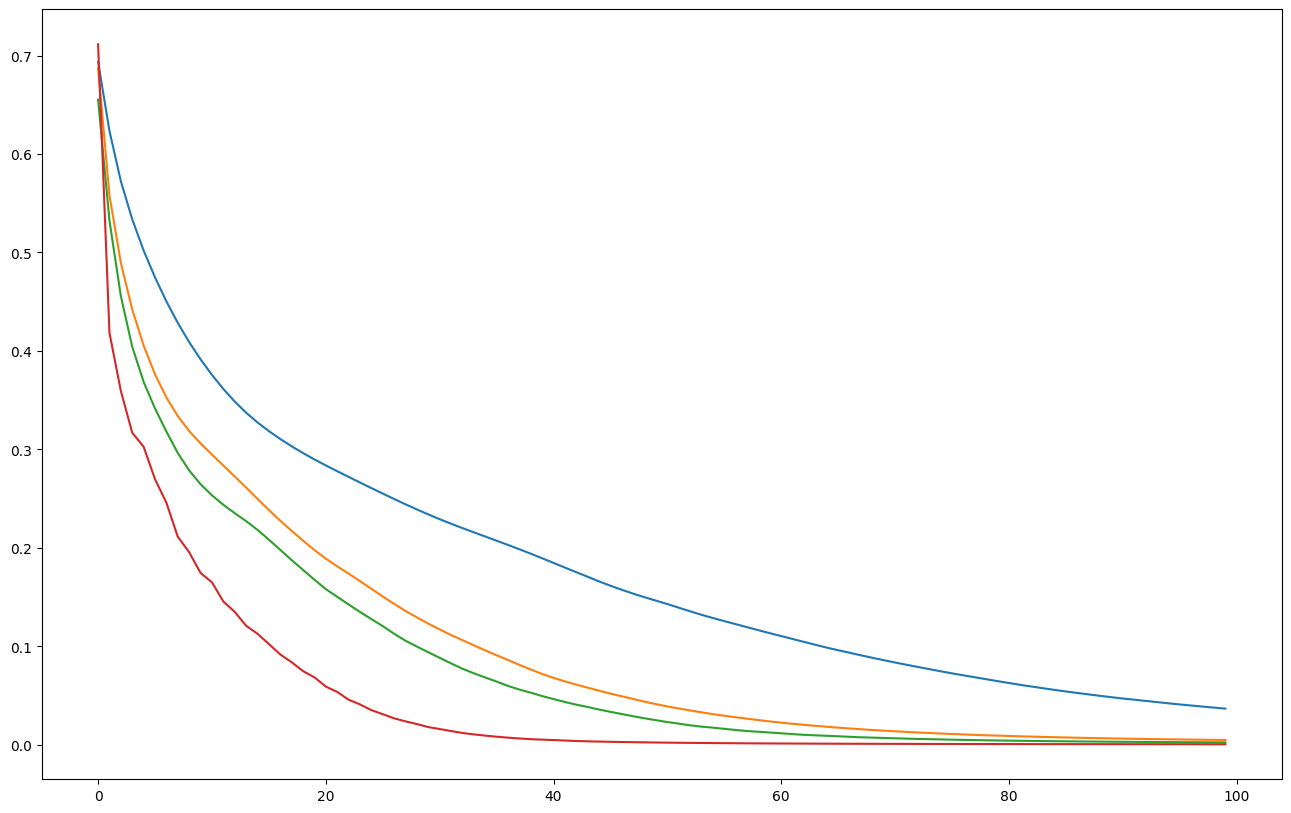

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,10))
features = ["raw", "kmeans", "pca", "autoencoder"]
optimizers = ["adam", "sgd", "momentum", "rmsprop"]
hp_algos = ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]

for feat in features:
    for opt in optimizers:
        for algo in hp_algos:
            loss_curve = results[feat][opt][algo + "_loss"]
            label_name = f"{feat}+{opt}+{algo}"
            plt.plot(loss_curve, label=label_name)

plt.title("Loss Curves per Epoch (Best Trial)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=6, ncol=3)
plt.grid(True)
plt.show()


In [131]:
def compact_params(hp_dict):
    # Convert long dict to short string, rounding floats
    if hp_dict is None:
        return ""
    return ", ".join(f"{k}={round(v, 4) if isinstance(v, float) else v}" for k, v in hp_dict.items())

rows = []

for feat_name, feat_dict in results.items():
    for opt_name, opt_dict in feat_dict.items():
        for algo in ["Grid", "Random", "Bayes", "Hyperband", "Evolutionary"]:
          met = opt_dict.get(f"{algo}_met", None)
          best_hp = opt_dict.get(algo, None)
          if met is not None:
              rows.append({
                  "Feature": feat_name,
                  "Optimizer": opt_name,
                  "HP Algorithm": algo,
                  "Accuracy": round(met.get("acc", 0), 4),
                  "Precision": round(met.get("prec", 0), 4),
                  "Recall": round(met.get("rec", 0), 4),
                  "F1": round(met.get("f1", 0), 4),
                  "AUC": round(met.get("auc", 0), 4),
                  "Best Params": compact_params(best_hp)
                })

table_clean = pd.DataFrame(rows)

# Export to LaTeX
latex_code = table_clean.to_latex(index=False, longtable=True)
print(latex_code)



\begin{longtable}{lllrrrrrl}
\toprule
Feature & Optimizer & HP Algorithm & Accuracy & Precision & Recall & F1 & AUC & Best Params \\
\midrule
\endfirsthead
\toprule
Feature & Optimizer & HP Algorithm & Accuracy & Precision & Recall & F1 & AUC & Best Params \\
\midrule
\endhead
\midrule
\multicolumn{9}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
raw & adam & Grid & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & lr=0.01, momentum=0.99, hidden_size=32, weight_decay=0.001, batch_size=32 \\
raw & adam & Random & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & lr=0.0216, momentum=0.763, hidden_size=32, weight_decay=0.0011, batch_size=16 \\
raw & adam & Bayes & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & lr=0.043, momentum=0.8427, hidden_size=16, weight_decay=0.0, batch_size=16 \\
raw & adam & Hyperband & 1.000000 & 1.000000 & 1.000000 & 1.000000 & 1.000000 & lr=0.0766, momentum=0.762, hidden_size=32, weight_decay=0.0003, batch_size=64 \\

In [103]:
print(results)

{'raw': {'adam': {'Grid': {'lr': 0.1, 'momentum': 0.8, 'hidden_size': 32, 'weight_decay': 0.001, 'batch_size': 64}, 'Grid_f1': 1.0, 'Grid_traj': [0.9642857142857143, 0.9642857142857143, 0.9824561403508771, 0.9642857142857143, 0.9824561403508771, 0.9333333333333333, 0.9354838709677419, 0.9824561403508771, 0.9152542372881356, 0.9642857142857143, 0.9056603773584906, 1.0, 0.9152542372881356, 1.0, 0.9655172413793104, 0.9830508474576272, 0.7037037037037037, 0.9824561403508771, 0.9642857142857143, 0.896551724137931, 0.9824561403508771, 0.9333333333333333, 0.8529411764705882, 0.7659574468085106, 0.9333333333333333], 'Grid_perf': [0.11721992492675781, 0.11702322959899902, 0.10458588600158691, 0.10058951377868652, 0.10280799865722656, 0.10272336006164551, 0.11278486251831055, 0.10515761375427246, 0.10055279731750488, 0.10846757888793945, 0.12395167350769043, 0.1053762435913086, 0.13118958473205566, 0.1631321907043457, 0.14582538604736328, 0.14435195922851562, 0.1454148292541504, 0.14723348617553